In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

     |████████████████████████████████| 993kB 43.0MB/s 


In [0]:
!rm -r logs/

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Téléchargement des données depuis Google Drive

In [0]:

zip_id = '1F4PaV8OqG7jPmV7dVIJaOea_2haDtzKe'
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Uncompressing zip file


In [0]:
zip_id = '19KVMoZUdFjEpU-yOIlgm7ZgOX72yU3me'
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('model.zip')
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Uncompressing zip file


In [0]:
def RgbToQuaternion(img):
 b,g,r = cv2.split(img)
 
 M=[]
 for i in range(r.shape[0]):
  t=[]
  for j in range(r.shape[1]):
   t.append([0.0,r[i][j],g[i][j],b[i][j]])
  M.append(t)
 M=np.array(M)/255.
 return(np.array(M))


In [0]:
def QuaternionToRgb(img):

 M=[]
 for i in range(img.shape[0]):
  t=[]
  for j in range(img.shape[1]):
   t.append([img[i][j][3],img[i][j][2],img[i][j][1]])
  M.append(t)
 M=np.array(M)*255
 return(np.array(M))


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content"
CATEGORIES = ["ARR", "CHF","NSR"]

# Prétraitement  des données Pour le Reseau Qcnn

In [0]:
training_data = []
allI1= []
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) )  # convert to array
                allI1.append(img_array)
                training_data.append([RgbToQuaternion(img_array), class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()
import random

random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
allI1 = np.array(allI1)
X = np.array(X)

y=np.array(y)

import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

100%|██████████| 36/36 [00:04<00:00,  7.67it/s]


# Augmentation des données

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,width_shift_range=0.1, height_shift_range=0.1,horizontal_flip=True)
datagen.fit(x_train)

In [0]:
import numpy                 as np
import keras                        
from   keras.optimizers      import *
from   keras.layers                          import *
from   keras.models                          import Model
import keras.backend                         as     K
from   complexnn             import *
from   sklearn.preprocessing import normalize
import sys
import argparse              as Ap
from tensorflow.keras.callbacks import TensorBoard
import time

In [0]:
from keras.optimizers import SGD
opt = adam(lr = 0.001,decay=1e-6)
dense_layers = [2]
layer_sizes = [64]
conv_layers = [3]

In [0]:
import keras.backend as K
import keras
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler
import logging as L

In [0]:


# Keep a history of the validation performance.
class TrainValHistory(Callback):
	def __init__(self):
		self.train_loss = []
		self.train_acc  = []
		self.val_loss   = []
		self.val_acc    = []

	def on_epoch_end(self, epoch, logs={}):
		self.train_loss.append(logs.get('loss'))
		self.train_acc .append(logs.get('acc'))
		self.val_loss  .append(logs.get('val_loss'))
		self.val_acc   .append(logs.get('val_acc'))



In [0]:
train_loss1 = []
train_acc1  = []
val_loss1   = []
val_acc1    = []




# Creation  et entrainement du Reseau Qcnn 

In [0]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "QCNN-{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            input_seq = Input((224, 224, 4))
            O    =QuaternionConv2D(layer_size, (5,5),activation='relu',padding='same')(input_seq)  
            O    = MaxPooling2D((4,4), padding='same')(O)
            for l in range(conv_layer-1):
              O    =QuaternionConv2D(layer_size, (5,5),activation='relu',padding='same')(O)  
              O    = MaxPooling2D((4,4), padding='same')(O)
            O    = Flatten()(O)
            for _ in range(dense_layer):
              O  = QuaternionDense(layer_size, activation='relu')(O)
            
            O = Dense(3, activation='softmax')(O)
            model=Model(input_seq, O)
            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
            trainValHistCb = TrainValHistory()
            mode="quaternion"
            callbacks = [trainValHistCb,tensorboard]
            model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),\
                    steps_per_epoch=X.shape[0] // 32,epochs=100,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=callbacks)
            
            train_loss1 = np.asarray(trainValHistCb.train_loss)
            train_acc1  = np.asarray(trainValHistCb.train_acc)
            val_loss1   = np.asarray(trainValHistCb.val_loss)
            val_acc1    = np.asarray(trainValHistCb.val_acc))
            
            np.savetxt('{}_train_loss.txt'.format(mode), np.asarray(trainValHistCb.train_loss))
            np.savetxt('{}_train_acc.txt'.format(mode), np.asarray(trainValHistCb.train_acc))
            np.savetxt('{}_val_loss.txt'.format(mode), np.asarray(trainValHistCb.val_loss))
            np.savetxt('{}_val_acc.txt'.format(mode), np.asarray(trainValHistCb.val_acc))
            #model.fit(x_train, y_train,validation_split=0.3,callbacks=[tensorboard],epochs=50,batch_size=32)
            
            


QCNN-3-conv-64-nodes-2-dense-1556957391
rank= 2
filters= 64
kernel_size= (5, 5)
input_dim= 1
 self.kernel_shape= (5, 5, 1, 64)  self.kernel_size=  (5, 5)  (input_dim , self.filters)= [1, 64]
self.kernel_size + (4 * input_dim, 4 * self.filters)= (5, 5, <tf.Tensor 'quaternion_conv2d_22/mul_1:0' shape=() dtype=int32>, 256)
rank= 2
filters= 64
kernel_size= (5, 5)
input_dim= 64
 self.kernel_shape= (5, 5, 64, 64)  self.kernel_size=  (5, 5)  (input_dim , self.filters)= [64, 64]
self.kernel_size + (4 * input_dim, 4 * self.filters)= (5, 5, <tf.Tensor 'quaternion_conv2d_23/mul_1:0' shape=() dtype=int32>, 256)
rank= 2
filters= 64
kernel_size= (5, 5)
input_dim= 64
 self.kernel_shape= (5, 5, 64, 64)  self.kernel_size=  (5, 5)  (input_dim , self.filters)= [64, 64]
self.kernel_size + (4 * input_dim, 4 * self.filters)= (5, 5, <tf.Tensor 'quaternion_conv2d_24/mul_1:0' shape=() dtype=int32>, 256)
Epoch 1/100
5/5 [==============================] - 4s 752ms/step - loss: 3.6287 - acc: 0.6493 - val_loss: 0.

In [0]:
train_loss1 = np.asarray(train_loss1.train_loss)
train_acc1  = np.asarray(train_acc1.train_acc)
val_loss1   = np.asarray(val_loss1.val_loss)
val_acc1    = np.asarray(val_acc1.val_acc)

# Matrice de confusion Qcnn

In [0]:
predictions = model.predict(X)
y_pred = (predictions > 0.5)
from sklearn.metrics import confusion_matrix
matrix =confusion_matrix(y, y_pred.argmax(axis=1))/1.
matrix[0,]=matrix[0,]/np.sum(matrix[0,])
matrix[1,]=matrix[1,]/np.sum(matrix[1,])
matrix[2,]=matrix[2,]/np.sum(matrix[2,])
matrix

array([[0.85, 0.1 , 0.04],
       [0.23, 0.77, 0.  ],
       [0.06, 0.  , 0.94]])

# Courbes Roc -Qcnn

In [0]:
!pip install scikit-plot

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


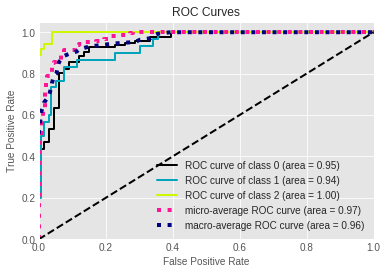

<Figure size 432x288 with 0 Axes>

In [0]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y, predictions)
plt.show()
plt.savefig('Roc.png')

# Prétraitement  des données Pour le Reseau Cnn

In [0]:
training_data = []
allI2= []
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) )  # convert to array
                allI2.append(img_array) 
                training_data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()
import random

random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

allI2 = np.array(allI2)
X = np.array(X)/255.
y=np.array(y)

import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)




100%|██████████| 36/36 [00:00<00:00, 1523.06it/s]


# Augmentation des données 

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90,width_shift_range=0.1, height_shift_range=0.1,horizontal_flip=True)
datagen.fit(x_train)
opt = Adam(lr = 0.0001,decay=1e-6)

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

In [0]:

dense_layers = [2]
layer_sizes = [64]
conv_layers = [3]

# Creation  et entrainement du Reseau Cnn 

In [0]:
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "CNN-{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (5, 5), input_shape=x_train.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(4, 4)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (5, 5)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(4, 4)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(512))
                model.add(Activation('relu'))
                model.add(Dropout(0.2))

            model.add(Dense(3))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='categorical_crossentropy',
                          optimizer=opt,
                          metrics=['accuracy'],
                          )

            model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),\
                    steps_per_epoch=X.shape[0] // 32,epochs=200,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[tensorboard])
            

CNN-3-conv-32-nodes-2-dense-1556967903
Epoch 1/200
5/5 [==============================] - 4s 796ms/step - loss: 1.0686 - acc: 0.5546 - val_loss: 1.0450 - val_acc: 0.5510
Epoch 2/200
5/5 [==============================] - 0s 43ms/step - loss: 1.0142 - acc: 0.6355 - val_loss: 1.0046 - val_acc: 0.5510
Epoch 3/200
5/5 [==============================] - 1s 211ms/step - loss: 0.9624 - acc: 0.6054 - val_loss: 0.9738 - val_acc: 0.5510
Epoch 4/200
5/5 [==============================] - 1s 239ms/step - loss: 0.9167 - acc: 0.6138 - val_loss: 0.9777 - val_acc: 0.5510
Epoch 5/200
5/5 [==============================] - 1s 264ms/step - loss: 0.9353 - acc: 0.6037 - val_loss: 1.0007 - val_acc: 0.5510
Epoch 6/200
5/5 [==============================] - 1s 265ms/step - loss: 0.8954 - acc: 0.6319 - val_loss: 1.0032 - val_acc: 0.5510
Epoch 7/200
5/5 [==============================] - 1s 260ms/step - loss: 0.8678 - acc: 0.6401 - val_loss: 0.9859 - val_acc: 0.5510
Epoch 8/200
5/5 [============================

# Matrice de confusion -Cnn

In [0]:
predictions = model.predict(X)
y_pred = (predictions > 0.5)
from sklearn.metrics import confusion_matrix
matrix =confusion_matrix(y, y_pred.argmax(axis=1))/1.
matrix[0,]=matrix[0,]/np.sum(matrix[0,])
matrix[1,]=matrix[1,]/np.sum(matrix[1,])
matrix[2,]=matrix[2,]/np.sum(matrix[2,])
matrix

array([[0.94, 0.06, 0.  ],
       [0.8 , 0.2 , 0.  ],
       [0.53, 0.  , 0.47]])

# Courbe Roc-Cnn

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


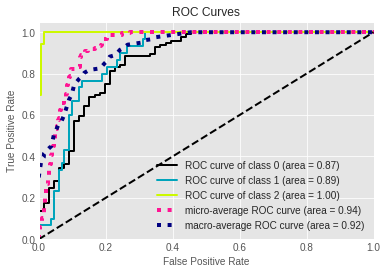

In [0]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc_curve(y, predictions)

plt.savefig('Roc2.png')
plt.show()



# Visualisation du Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-03 15:16:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.130.40, 52.22.145.207, 52.201.75.180, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.130.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14991793 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.30M  18.5MB/s    in 0.8s    

2019-05-03 15:16:50 (18.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14991793/14991793]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = 'logs/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6005 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6005 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c424870c.ngrok.io
